In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

# Задание 1

### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Для начала прочитаем данные и поменяем тип столбца с временем регистрации/входа в игру на более привычный %Y-%m-%d

In [443]:
visit_time = pd.read_csv('problem1-auth_data.csv', sep = ';')
reg_time = pd.read_csv('problem1-reg_data.csv', sep = ';')

In [444]:
reg_time['reg_ts'] = pd.to_datetime(reg_time.reg_ts, unit = 's')
reg_time['reg_ts'] = reg_time['reg_ts'].dt.strftime('%Y-%m-%d')

In [445]:
visit_time['auth_ts'] = pd.to_datetime(visit_time.auth_ts, unit = 's')
visit_time['auth_ts'] = visit_time['auth_ts'].dt.strftime('%Y-%m-%d')

В силу того, что данные охватывают большой период времени, было решено реализовать функцию retention следующим образом. 
Функция берет на вход обе таблицы и некоторую дату регистрации, с которой необходимо вести отсчет. Для последующих дат вычисляется количество людей посетивших игру. Столбец retention rate в данной таблице указывает на долю вошедших в игру от общего числа зарегестрированных в заданную дату пользователей

In [446]:
def retention(reg_time, visit_time, date):
    df_sample = reg_time.merge(visit_time, on = 'uid', how = 'right')
    df_sample = df_sample[['uid', 'reg_ts', 'auth_ts']]
    df_sample = df_sample.query('reg_ts == @date')
    df_sample['reg_ts'] = pd.to_datetime(df_sample['reg_ts'])
    df_sample['auth_ts'] = pd.to_datetime(df_sample['auth_ts'])
    df_sample['day_count'] = df_sample['auth_ts'] - df_sample['reg_ts']
    df_sample['day_count'] = df_sample['day_count'].dt.days.astype(int)
    #не учитываем людей которые несколько раз заходили в игру в один и тот же день
    df_sample = df_sample.drop_duplicates(subset = ['uid', 'auth_ts'])
    n = df_sample.uid.nunique()
    df_sample = df_sample.groupby('day_count', as_index = False).agg({'uid': 'count'}).rename(columns = {'uid': 'retention'})
    df_sample['retention_rate'] = df_sample.retention / n
    return df_sample

In [464]:
df_sample = visit_time.sample(750000)

In [468]:
sample_retention = retention(reg_time, df_sample, '2018-08-12') 
sample_retention.head()

,day_count,retention,retention_rate
0,0,34,0.465753
1,2,2,0.027397
2,3,2,0.027397
3,5,4,0.054795
4,6,2,0.027397


In [469]:
general_retention = retention(reg_time, visit_time, '2018-08-12')
general_retention.head()

,day_count,retention,retention_rate
0,0,461,1.000000
1,1,5,0.010846
2,2,12,0.026030
3,3,22,0.047722
4,4,24,0.052061


Тест функции на выборке из 750000 человек

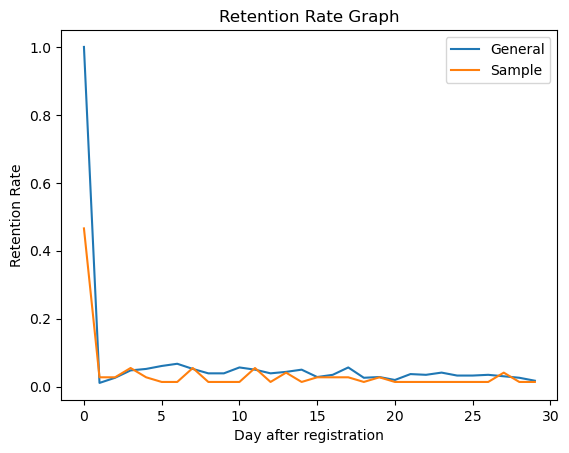

In [470]:
#Для наглядности в визуализации возьмем только первые 30 дней с даты регистрации
general_retention = general_retention.head(30)
sample_retention = sample_retention.head(30)
sns.lineplot(x = general_retention.day_count, y = general_retention.retention_rate, label='General')
sns.lineplot(x = general_retention.day_count, y = sample_retention.retention_rate, label='Sample')
plt.xlabel('Day after registration')
plt.ylabel('Retention Rate')
plt.title('Retention Rate Graph')
plt.legend()
plt.show()


Также приведу функцию  расчета retention, которая на мой взгляд может быть полезнее с практической точки зрения. advanced_retention получает на вход датасет с активностью пользователей и некоторый год для которого будет приведена статистика retention. В одном из следующих пунктов проекта сказано, что ежемесячно в игре появляются новые акционные предложения. Поэтому я считаю релевантным взять месяц единицей отсчета параметра retention. Итак данная функция для каждого месяца заданного года вычисляет долю пользователей активных в следующем месяце от числа активных в текущем. То есть если в январе в игру играло 3 тысячи человек, а в феврале из этих 3 тысяч в игру вернулось полторы тысячи, то retention rate = 0.5. В данном случае не так важна дата регистрации пользователя, поэтому таблица reg_time не включена в функцию.

In [471]:
def advanced_retention(df, year):
    #приводим столбец auth_ts к типу datetime нс случай, если это еще не было сделано
    df['auth_ts'] = pd.to_datetime(df['auth_ts'])
    #оставляем только наблюдения за нужный период
    df = df[(df['auth_ts'].dt.year == year) | ((df['auth_ts'].dt.year == year + 1) & (df['auth_ts'].dt.month == 1))]
    #от даты оставляем только значение месяца. также для расчета retention декабря берем первый месяц следующего года
    df['month'] = df.auth_ts.apply(lambda x: x.month if x.year == year else 13)
    #считаем количество уникальный пользователей в каждом из месяцев
    df_all = df.groupby('month', as_index = False).agg({'uid': 'nunique'})
    #формируем таблицу с игроками посетившими приложение в следующем месяце
    df_res = df.drop_duplicates(subset = ['uid', 'month'])
    df_res = df_res.sort_values(['uid', 'month'])
    df_res['next_month'] = df_res.groupby('uid')['month'].shift(-1)
    df_res = df_res.dropna()
    df_res['dif'] = df_res.next_month - df_res.month
    df_res = df_res.reset_index()
    df_res = df_res.query('dif == 1').groupby('month', as_index = False).agg({'index': 'count'})
    #объединяем таблицы
    df_final = df_all.merge(df_res, on = 'month', how = 'left')
    df_final = df_final.rename(columns = {'uid': 'was', 'index': 'came_back'}).dropna()
    df_final['retention_rate'] = df_final.came_back / df_final.was
    df_final['month'] = pd.to_datetime(df_final['month'], format='%m').dt.strftime('%B') 
    return df_final

In [488]:
#Пример работы функции на полном объеме данных с заданным годом
res_df = advanced_retention(visit_time, 2015)
res_df

,month,was,came_back,retention_rate
0,January,3459,1917.0,0.554206
1,February,3505,2009.0,0.573181
2,March,3855,2145.0,0.556420
3,April,4023,2253.0,0.560030
4,May,4293,2346.0,0.546471
5,June,4423,2472.0,0.558897
6,July,4728,2581.0,0.545897
7,August,4954,2725.0,0.550061
8,September,5141,2897.0,0.563509
9,October,5521,2977.0,0.539214


<Axes: xlabel='month', ylabel='retention_rate'>

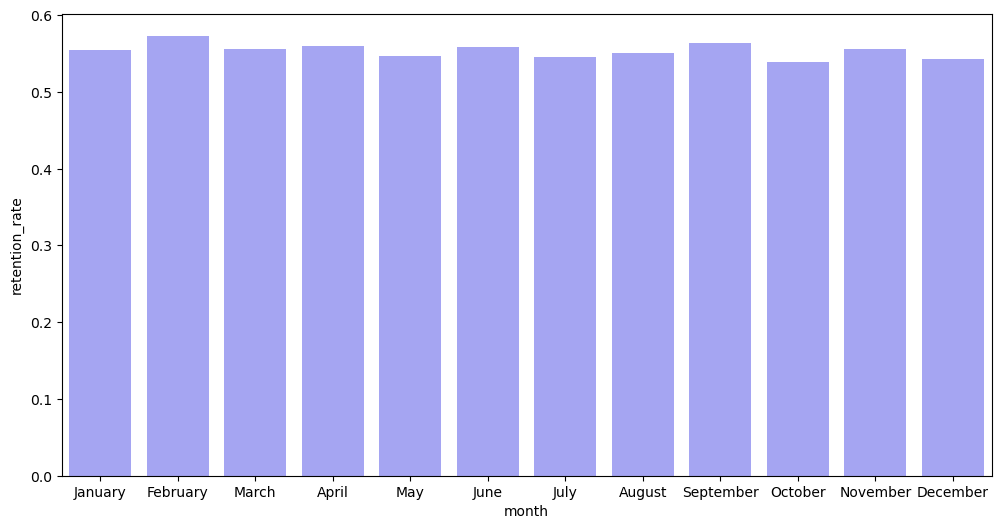

In [497]:
plt.figure(figsize=(12, 6)) 
sns.barplot(x = res_df.month, y = res_df.retention_rate, color = 'blue', alpha = 0.4)

## Задание 2

### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [490]:
df2 = pd.read_csv('Проект_1_Задание_2 (1).csv', sep = ';')
df2

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Для начала проверим насколько наблюдения из группы а статистически отличаются от представленного в группе b. Для этого составим таблицу сопряженности и используем критерий хи-квадрат

In [491]:
df2_chi = df2
df2_chi['revenue'] = df2_chi['revenue'].apply(lambda x: 1 if x > 0 else 0)
# df2a = df2_chi.query('testgroup == "a"')
# df2b = df2_chi.query('testgroup == "b"')
df2_chi = df2_chi.groupby('testgroup', as_index = False).agg({'revenue': 'sum', 'user_id': 'count'})
df2_chi['user_id'] = df2_chi['user_id'] - df2_chi['revenue']
df2_chi = df2_chi.rename(columns = {'user_id': '0', 'revenue': '1'}).set_index('testgroup').T
df2_chi

testgroup,a,b
1,1928,1805
0,200175,200862


In [492]:
from scipy.stats import chi2_contingency
result = chi2_contingency(df2_chi, correction = False)
result

Chi2ContingencyResult(statistic=4.443784139483562, pvalue=0.03502852464285541, dof=1, expected_freq=array([[  1863.89924896,   1869.10075104],
       [200239.10075104, 200797.89924896]]))

In [494]:
#Подсчитаем значение хи-квадрат вручную, убедимся, что оно достаточно мало. 
(1863.89924896 - 1928)**2 / 1863.89924896 + (1869.10075104 - 1805)**2 / 1869.10075104 + \
(200239.10075104 - 200175)**2 / 200239.10075104 + (200862 - 200797.89924896)**2 / 200797.89924896

4.443784138956332

В силу малого значения pvalue можем отклонить нулевую гипотезу о независимости распределения от группы. Следовательно между группами А и B существует статистически значимое различие. 

Можно сделать вывод о том, что в контрольной группе количество людей, воспользовавшихся акционным предложением больше, чем в тестовой и данное различие является статистически значимым. Однако доход с пользователя в тестовой группе оказался выше

Поскольку средняя прибыль с клиента в тестовой группе оказалась выше, чем таковая в контрольной предварительно можно одобрить внедрение новых акционных предложений. Однако в связи с этим следует сделать несколько оговорок.

Для того чтобы понять какой из наборов предложений можно считать лучшим дополнительно стоит проанализировать такую метрика как CAС. Данная метрика вычисляется как частное расходов на привлечение и числа клиентов и показывает сколько стоит привлечение одного клиента. Поскольку тестовая группа показала себя как более прибыльная для компании релевантным было бы увеличить число клиентов и именно для этого необходимо понимать, насколько дорого будет стоить их привлечение.

Также необходимо посмотреть, насколько введение нового акционного предложения повлияет на такие метрики как LTV (пожизненная ценность клиента) и ARPPU (средний доход на платящего пользователя). Если новая акция снижает дальнейшую финансовую активность клиента в продукте, то необходимо откорректировать условия акции. 

# Задание 3

### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Вообще, тематическое событие можно рассматривать как маркетинговую кампанию, поскольку на ее разработку необходимы средства и ее целью в конечном итоте является увеличение числа активных пользователей, а также конверсия пользователей в клиентов. Таким образом, можно взять для анализа все сопряженные метрики: средняя месячная аудитория (MAU) для оценки количества пользователей и CR пользователей в клиентов. Для непосредственной оценки проведения тематического события, которое мы условились называть маркетинговой кампанией, можно отследить изменение таких метрик как CPAcq и CAC до и после события, включая в расходы траты на его создания. После окончания тематического события необходимо отследить какая доля пользователей, участвовавших в нем, осталась активными игроками. В этом нам поможет метрика Retention Rate. 

### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

В данном случае все метрики перечисленные выше все еще актуальны. Однако в рассмотрение стоит также включить такую метрику как CSAT (оценка удовлетворенности пользователей), которая показывает процентную долю положительных отзывов относительно общего их числа. Использование этой метрики необходимо в силу того, что игра в потенциале может вызывать у пользователя менее позитивные эмоции в связи с ее сложностью. Поэтому нужно отследить, как много людей решило поделиться своим недовольством во время проведения тематического события. Особенно актуальным это может стать, если в игре есть возможность заплатить за возможность не откатываться на предыдущие уровни внутриигровой валютой, покупаемой за реальные деньги. В таком случае часть пользователей действительно конвертируются в клиентов и показатели метрик связанных с прибылью увеличатся, однако CSAT упадет, а вместе с ней может упасть и метрика LTV, поскольку число лояльных приложению пользователей скорее всего сократится в силу снижения репутации игры. 
Также усложение игры, предложенное в условии, приводит к тому, что пользователь проводит в ней большее количество времени. То есть метрика ASL (средняя продолжительность сессии) увеличивается. И в этом контексте было бы интересно рассмотреть то, насколько продолжительность игровой сессии в среднем увеличится уже после тематического события, а также понять связь между ASL и конверсией в клиента.